1. Understanding the dataset

Title: Haberman’s Survival Data


Description: The dataset contains cases from a study that was conducted between 1958 and 1970 
at the University of Chicago’s Billings Hospital on the survival of patients who had undergone 
surgery for breast cancer.


Attribute Information:
Age of patient at the time of operation (numerical) 

Patient’s year of operation (year — 1900, numerical)

Number of positive axillary nodes detected (numerical)

Survival status (class attribute) :

    1 = the patient survived 5 years or longer
    
    2 = the patient died within 5 years

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df=pd.read_csv('haberman.csv', names=['Age of Patient','Patient\'s year of operation',
                                      'positive axillary nodes','Survival Status'])
df['Survival Status']=df['Survival Status'].replace({1:0, 2:1})

rate_of_patients_dying_whithin_5_years=round(len(df.loc[df['Survival Status']==1,:])/len(df), 4)
print('{} is the rate of patients dying whithin 5 years'.format(rate_of_patients_dying_whithin_5_years))
df.head(10) 

0.2647 is the rate of patients dying whithin 5 years


,Age of Patient,Patient's year of operation,positive axillary nodes,Survival Status
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0
5,33,58,10,0
6,33,60,0,0
7,34,59,0,1
8,34,66,9,1
9,34,58,30,0


In [5]:
df=df.apply(lambda x: pd.to_numeric(x)) 
X,y=df.iloc[:,:-1], df.iloc[:,-1] 

scaler = MinMaxScaler()    
X=scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_test, y_train, y_test = (np.array(X_train).T, np.array(X_test).T, 
                                    np.array(y_train).reshape(1,-1), 
                                    np.array(y_test).reshape(1,-1)) 

NOW, OUR DATA IS READY TO BE PROCESSED. LET'S BUILD A NEURAL NETWORK!

In [6]:
def initialization(layer_dims): #layer_dims has to be a list
    np.random.seed(1)  # to reproduce values
    parameters={}
    for l in range(1,len(layer_dims)):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.01 
        parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
    return parameters

In [7]:
# Let's run a example
yey=initialization([X_train.shape[0], 10, 4, 1]) 
len(yey)/2#['b2'].shape
# X_train[:,1].shape

3.0

In [8]:
# sigmoid as activation function in last layer, ReLU for remaining ones
def forward_propagation_AND_cost_computation(X, Y, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  

    Y=Y.reshape(1,-1) 
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)
    #str(len(forward_param)/2)[0] returns '2.0'[0], which is only '2'
    m=Y.shape[1] 

    cost=-(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))   
    
    return cost, forward_param, parameters

In [9]:
1-np.array([0.8,.4,.3])

array([0.2, 0.6, 0.7])

In [10]:
forward_propagation_AND_cost_computation(X_train[:,1].reshape(-1,1), y_train[:,1].reshape(-1,1),
                                         initialization([X_train.shape[0], 10, 4, 1]))  

(0.6931462163190072, {'Z1': array([[ 0.01185292],
         [-0.00986829],
         [ 0.01341381],
         [-0.00346676],
         [-0.00156121],
         [-0.00897634],
         [-0.00052804],
         [ 0.00902596],
         [ 0.00670438],
         [-0.00665445]]), 'A1': array([[0.01185292],
         [0.        ],
         [0.01341381],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.00902596],
         [0.00670438],
         [0.        ]]), 'Z2': array([[-4.17202944e-05],
         [ 7.46635864e-05],
         [-1.44884557e-05],
         [ 2.63092545e-04]]), 'A2': array([[0.00000000e+00],
         [7.46635864e-05],
         [0.00000000e+00],
         [2.63092545e-04]]), 'Z3': array([[1.92848281e-06]]), 'A3': array([[0.50000048]])}, {'W1': array([[ 0.01624345, -0.00611756, -0.00528172],
         [-0.01072969,  0.00865408, -0.02301539],
         [ 0.01744812, -0.00761207,  0.00319039],
         [-0.0024937 ,  0.01462108, -0.0206014

In [11]:
def backward_propagation(X, Y, parameters):
    loss, forward_param, weights = forward_propagation_AND_cost_computation(X, Y, parameters) #'forward_param' -> 'As' and 'Zs'
    grads={}
    last_layer = int(len(forward_param)/2) 
    m=Y.shape[1] 
    forward_param['A0']=X
    
    grads['dZ'+str(last_layer)]=forward_param['A'+str(last_layer)] - Y #here activation: sigmoid.
                                                                       #following layers: ReLU
    previous_dZ=grads['dZ'+str(last_layer)]
    for l in reversed(range(1,last_layer+1)):
        grads['dW'+str(l)] = ((1/m) * np.dot(previous_dZ, 
                                               forward_param['A'+str(l-1)].T))   
        grads['db'+str(l)] = (1/m) * np.sum(previous_dZ, axis=1, keepdims=True)
        
        if l>1:
            grads['dZ'+str(l-1)] = (np.dot(weights['W'+str(l)].T, previous_dZ) * 
                                    np.array(forward_param['Z'+str(l-1)]>=0, dtype=float))    
            
            previous_dZ = grads['dZ'+str(l-1)]
            
    return grads

In [12]:
def gradient_update(parameters, grads, learning_rate=.1):
    for l in range(1, int(len(parameters)/2+1)):    
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)] 
    return parameters

In [13]:
def L_model(layer_dims, X, Y, number_of_iterations):
    layer_dims=layer_dims
    previous_parameters = initialization(layer_dims)
    values=[]
    for i in range(number_of_iterations):
        loss, forward_param, previous_parameters = forward_propagation_AND_cost_computation(X, Y, previous_parameters)
        
        values.append(loss)
        
        grads = backward_propagation(X, Y, previous_parameters)
        if i%100==0:
            print('iteration {}, cost: {}'.format(i,loss)) 
#             print(forward_param['A'+str(int(len(layer_dims)-1))]) 

        previous_parameters = gradient_update(previous_parameters, grads) 
    
    y=Y
    y_hat=forward_param['A'+str(int(len(previous_parameters)/2))] 
    
    accuracy=np.array(y==np.array(y_hat>0.5, dtype=float), dtype=float)

    print('\n\n accuracy: {}'.format(round(np.sum(accuracy)/len(accuracy[0]),3)))   
    
    plt.plot(np.squeeze(values))  
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning Process")
    plt.show() 

iteration 0, cost: 0.6931466650394417
iteration 100, cost: 0.527573004018059
iteration 200, cost: 0.5248779540120293
iteration 300, cost: 0.5248019765862207
iteration 400, cost: 0.5247995637974026
iteration 500, cost: 0.5247994310976457
iteration 600, cost: 0.5247993748924463
iteration 700, cost: 0.5247993175304493
iteration 800, cost: 0.5247992581586526
iteration 900, cost: 0.5247992021064067


 accuracy: 0.782


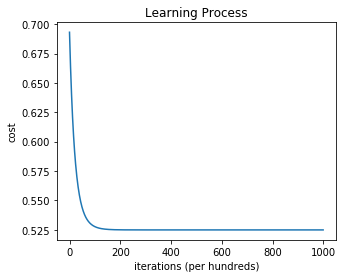

In [17]:
L_model([X_train.shape[0],20,7,1], X_train, y_train, 1000)  